# Tree-Based Algorithms Approach on Predicting Customer Satisfaction

# 
Brazilian E-Commerce Public Dataset by Olist:
https://www.kaggle.com/olistbr/brazilian-ecommerce

# Import libraries

In [290]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier

# Import & preprocessing datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## order and order review datasets

In [3]:
order_reviews = pd.read_csv('/content/drive/MyDrive/dataset/olist_order_reviews_dataset.csv')
order_reviews.shape

(99224, 7)

In [4]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
orders = pd.read_csv('/content/drive/MyDrive/dataset/olist_orders_dataset.csv')
orders.shape

(99441, 8)

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
#merge
df=pd.merge(orders,order_reviews,on="order_id")
df.shape

(99224, 14)

In [8]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [9]:
#get rating count
df["review_score"].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99224 entries, 0 to 99223
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99224 non-null  object
 1   customer_id                    99224 non-null  object
 2   order_status                   99224 non-null  object
 3   order_purchase_timestamp       99224 non-null  object
 4   order_approved_at              99068 non-null  object
 5   order_delivered_carrier_date   97468 non-null  object
 6   order_delivered_customer_date  96359 non-null  object
 7   order_estimated_delivery_date  99224 non-null  object
 8   review_id                      99224 non-null  object
 9   review_score                   99224 non-null  int64 
 10  review_comment_title           11568 non-null  object
 11  review_comment_message         40977 non-null  object
 12  review_creation_date           99224 non-null  object
 13  r

In [11]:
#drop 3 ratings as we are going to deal with only 1,2,4,5 (1,2)-not good (4,5)-good
df_1=df.drop(df[df["review_score"]==3].index)

In [12]:
df_1["review_score"].value_counts()

5    57328
4    19142
1    11424
2     3151
Name: review_score, dtype: int64

In [14]:
df_1["order_status"].value_counts()

delivered      88400
shipped          933
unavailable      562
canceled         561
invoiced         297
processing       287
created            3
approved           2
Name: order_status, dtype: int64

In [15]:
#drop cancelled orders that have ratings 4 and 5 because cancelled  orders cannot have rating of 4 and 5 but can have 1 and 2 due to some discomfort but not necessarily
df_2=df_1.drop(df_1[(df_1["order_status"]=="canceled")&(df_1["review_score"]>=4)].index)

In [17]:
df_2["review_score"].value_counts()

5    57259
4    19116
1    11424
2     3151
Name: review_score, dtype: int64

In [18]:
df_2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [19]:
#convert to date type
df_2['order_purchase_timestamp'] = pd.to_datetime(df_2['order_purchase_timestamp']).dt.date
df_2['order_approved_at'] = pd.to_datetime(df_2['order_approved_at']).dt.date
df_2['order_delivered_carrier_date'] = pd.to_datetime(df_2['order_delivered_carrier_date']).dt.date
df_2['order_delivered_customer_date'] = pd.to_datetime(df_2['order_delivered_customer_date']).dt.date
df_2['order_estimated_delivery_date'] = pd.to_datetime(df_2['order_estimated_delivery_date']).dt.date
df_2['review_creation_date'] = pd.to_datetime(df_2['review_creation_date']).dt.date
df_2['review_answer_timestamp'] = pd.to_datetime(df_2['review_answer_timestamp']).dt.date


In [20]:
df_2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18,2018-08-22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03,2017-12-05
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17,2018-02-18


In [22]:
#drop if reviews are answered before purchsing
df_3=df_2.drop(df_2[df_2["order_purchase_timestamp"]>df_2["review_answer_timestamp"]].index)

In [23]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90909 entries, 0 to 99223
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       90909 non-null  object
 1   customer_id                    90909 non-null  object
 2   order_status                   90909 non-null  object
 3   order_purchase_timestamp       90909 non-null  object
 4   order_approved_at              90851 non-null  object
 5   order_delivered_carrier_date   89377 non-null  object
 6   order_delivered_customer_date  88391 non-null  object
 7   order_estimated_delivery_date  90909 non-null  object
 8   review_id                      90909 non-null  object
 9   review_score                   90909 non-null  int64 
 10  review_comment_title           10709 non-null  object
 11  review_comment_message         37350 non-null  object
 12  review_creation_date           90909 non-null  object
 13  r

In [24]:
#drop review title and messages
df_4=df_3.drop(columns=["review_comment_title","review_comment_message"])

In [25]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90909 entries, 0 to 99223
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       90909 non-null  object
 1   customer_id                    90909 non-null  object
 2   order_status                   90909 non-null  object
 3   order_purchase_timestamp       90909 non-null  object
 4   order_approved_at              90851 non-null  object
 5   order_delivered_carrier_date   89377 non-null  object
 6   order_delivered_customer_date  88391 non-null  object
 7   order_estimated_delivery_date  90909 non-null  object
 8   review_id                      90909 non-null  object
 9   review_score                   90909 non-null  int64 
 10  review_creation_date           90909 non-null  object
 11  review_answer_timestamp        90909 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.0+ MB


##order item dataset

In [26]:
order_items = pd.read_csv('/content/drive/MyDrive/dataset/olist_order_items_dataset.csv')
order_items.shape

(112650, 7)

In [27]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [28]:
df_5=pd.merge(df_4,order_items,on="order_id")
df_5.shape

(102886, 18)

In [29]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102886 entries, 0 to 102885
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       102886 non-null  object 
 1   customer_id                    102886 non-null  object 
 2   order_status                   102886 non-null  object 
 3   order_purchase_timestamp       102886 non-null  object 
 4   order_approved_at              102872 non-null  object 
 5   order_delivered_carrier_date   101806 non-null  object 
 6   order_delivered_customer_date  100762 non-null  object 
 7   order_estimated_delivery_date  102886 non-null  object 
 8   review_id                      102886 non-null  object 
 9   review_score                   102886 non-null  int64  
 10  review_creation_date           102886 non-null  object 
 11  review_answer_timestamp        102886 non-null  object 
 12  order_item_id                 

In [30]:
df_5['shipping_limit_date'] = pd.to_datetime(df_5['shipping_limit_date']).dt.date

In [31]:
df_5.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,8d5266042046a06655c8db133d120ba5,4,2018-08-08,2018-08-08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18,2018-08-22,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,359d03e676b3c069f62cadba8dd3f6e8,5,2017-12-03,2017-12-05,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,e50934924e227544ba8246aeb3770dd4,5,2018-02-17,2018-02-18,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19,19.90,8.72


##order payements dataset

In [32]:
order_payments = pd.read_csv('/content/drive/MyDrive/dataset/olist_order_payments_dataset.csv')
order_payments.shape

(103886, 5)

In [33]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [34]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [35]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [36]:
df_6=pd.merge(df_5,order_payments,on="order_id")
df_6.shape

(107422, 22)

In [37]:
df_6.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,8d5266042046a06655c8db133d120ba5,4,2018-08-08,2018-08-08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30,118.70,22.76,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18,2018-08-22,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13,159.90,19.22,1,credit_card,3,179.12


##customer dataset

In [38]:
customer = pd.read_csv('/content/drive/MyDrive/dataset/olist_customers_dataset.csv')
print(customer.shape)

(99441, 5)


In [39]:
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [40]:
customer["customer_unique_id"].nunique()

96096

In [41]:
c=customer.drop(columns="customer_id")

In [43]:
#there are some customers with two different  addresses dropping them (different city and state not considering pin code because a city can have different pincode)
def get_cust(data):
  custz={}
  custc={}
  custs={}
  ncustz={}
  ncustc={}
  ncusts={}

  for i,row in data.iterrows():
    z=custz.get(row[1],0)
    c=custc.get(row[1],0)
    s=custs.get(row[1],0)
    if z ==0:
      custz[row[1]]=row[2]
    elif z!=0 and custz[row[1]]!=row[2]:
            ncustz[row[1]]=row[2]

    if c==0 :
            custc[row[1]]=row[3]

    elif c!=0 and custc[row[1]]!=row[3]:
            ncustc[row[1]]=row[3]

    if s==0:
              custs[row[1]]=row[4]

    elif s!=0 and custs[row[1]]!=row[4]:
                ncusts[row[1]]=row[4]

  return custz,custc,custs,ncustz,ncustc,ncusts

In [44]:
z,c,s,nz,nc,ns=get_cust(customer)

In [45]:
print(len(nz),len(nc),len(ns))

250 122 39


In [46]:
dup=list(list(nc.keys())+list(ns.keys()))

In [47]:
dup1=set(dup)

In [48]:
len(dup1)

122

In [49]:
h=[]
for val in dup1:
 h.append(customer[customer["customer_unique_id"]==val].index)

In [50]:
t=[]
for v in h:
  t.extend(v[i] for i in range(len(v)))

In [56]:
cust=customer.drop(index=t)

In [57]:
cust.shape

(99184, 5)

In [58]:
cust.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [59]:
df_7=pd.merge(df_6,cust,on="customer_id")
df_7.shape

(107124, 26)

In [60]:
df_7.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,8d5266042046a06655c8db133d120ba5,4,2018-08-08,2018-08-08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18,2018-08-22,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


##products dataset

In [61]:
products = pd.read_csv('/content/drive/MyDrive/dataset/olist_products_dataset.csv')
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [62]:
products.shape

(32951, 9)

In [63]:
products.nunique()

product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

In [64]:
df_8=pd.merge(df_7,products,on="product_id")
df_8.shape

(107124, 34)

In [65]:
df_8.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,b46f1e34512b0f4c74a72398b03ca788,4,2017-08-19,2017-08-20,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21,29.99,7.78,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,dc90f19c2806f1abba9e72ad3c350073,5,2017-08-08,2017-08-08,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08,29.99,7.78,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


# seller dataset

In [66]:
sellers = pd.read_csv('/content/drive/MyDrive/dataset/olist_sellers_dataset.csv')
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [67]:
sellers.shape

(3095, 4)

In [68]:
df_9=pd.merge(df_8,sellers,on="seller_id")
df_9.shape

(107124, 37)

##product translation

In [72]:
product_translation = pd.read_csv('/content/drive/MyDrive/dataset/product_category_name_translation.csv')
product_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [73]:
product_translation.nunique()

product_category_name            71
product_category_name_english    71
dtype: int64

In [192]:
df9=pd.merge(df_9,product_translation,on="product_category_name")

In [193]:
df9.shape

(105528, 38)

In [194]:
df9.drop("product_category_name",axis=1,inplace=True)

In [195]:
df9.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'product_category_name_english'],
      dtype='object')

In [196]:
df_ecommerce = df9[['customer_zip_code_prefix', 'customer_city',  'customer_state','order_status','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date',
                              'shipping_limit_date','payment_sequential','payment_type','payment_installments','payment_value',
                              'price','freight_value','product_category_name_english','product_name_lenght','product_description_lenght',
                              'product_photos_qty','review_creation_date','product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm','review_answer_timestamp','review_score', 'seller_zip_code_prefix', 'seller_city', 'seller_state']]
df_ecommerce = df_ecommerce.rename(columns={'product_name_lenght': 'product_name_length', 'product_description_lenght': 'product_description_length',
                                            'product_category_name_english': 'product_category'})
df_ecommerce.head()

,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value,product_category,product_name_length,product_description_length,product_photos_qty,review_creation_date,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_answer_timestamp,review_score,seller_zip_code_prefix,seller_city,seller_state
0,3149,sao paulo,SP,delivered,2017-10-02,2017-10-04,2017-10-10,2017-10-18,2017-10-06,1,credit_card,1,18.12,29.99,8.72,housewares,40.0,268.0,4.0,2017-10-11,500.0,19.0,8.0,13.0,2017-10-12,4,9350,maua,SP
1,3149,sao paulo,SP,delivered,2017-10-02,2017-10-04,2017-10-10,2017-10-18,2017-10-06,3,voucher,1,2.00,29.99,8.72,housewares,40.0,268.0,4.0,2017-10-11,500.0,19.0,8.0,13.0,2017-10-12,4,9350,maua,SP
2,3149,sao paulo,SP,delivered,2017-10-02,2017-10-04,2017-10-10,2017-10-18,2017-10-06,2,voucher,1,18.59,29.99,8.72,housewares,40.0,268.0,4.0,2017-10-11,500.0,19.0,8.0,13.0,2017-10-12,4,9350,maua,SP
3,3366,sao paulo,SP,delivered,2017-08-15,2017-08-17,2017-08-18,2017-08-28,2017-08-21,1,credit_card,3,37.77,29.99,7.78,housewares,40.0,268.0,4.0,2017-08-19,500.0,19.0,8.0,13.0,2017-08-20,4,9350,maua,SP
4,2290,sao paulo,SP,delivered,2017-08-02,2017-08-04,2017-08-07,2017-08-15,2017-08-08,1,credit_card,1,37.77,29.99,7.78,housewares,40.0,268.0,4.0,2017-08-08,500.0,19.0,8.0,13.0,2017-08-08,5,9350,maua,SP


In [197]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105528 entries, 0 to 105527
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_zip_code_prefix       105528 non-null  int64  
 1   customer_city                  105528 non-null  object 
 2   customer_state                 105528 non-null  object 
 3   order_status                   105528 non-null  object 
 4   order_purchase_timestamp       105528 non-null  object 
 5   order_delivered_carrier_date   104446 non-null  object 
 6   order_delivered_customer_date  103381 non-null  object 
 7   order_estimated_delivery_date  105528 non-null  object 
 8   shipping_limit_date            105528 non-null  object 
 9   payment_sequential             105528 non-null  int64  
 10  payment_type                   105528 non-null  object 
 11  payment_installments           105528 non-null  int64  
 12  payment_value                 

In [198]:
df_ecommerce.shape

(105528, 29)

# Check null values and drop

In [199]:
df_ecommerce.isnull().sum()

customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_status                        0
order_purchase_timestamp            0
order_delivered_carrier_date     1082
order_delivered_customer_date    2147
order_estimated_delivery_date       0
shipping_limit_date                 0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
price                               0
freight_value                       0
product_category                    0
product_name_length                 0
product_description_length          0
product_photos_qty                  0
review_creation_date                0
product_weight_g                    1
product_length_cm                   1
product_height_cm                   1
product_width_cm                    1
review_answer_timestamp             0
review_score                        0
seller_zip_c

In [200]:
prev_size = df_ecommerce.shape[0]
df_ecommerce.dropna(how='any',inplace=True)
current_size = df_ecommerce.shape[0]
df_ecommerce.isnull().values.any()
print(df_ecommerce.shape)
print('From the data cleaning, we remove {}% of NaN value data'.format(round(((prev_size - current_size)/prev_size)*100,2)))

(103379, 29)
From the data cleaning, we remove 2.04% of NaN value data


In [201]:
df_ecommerce['order_purchase_timestamp'] = pd.to_datetime(df_ecommerce['order_purchase_timestamp']).dt.date
df_ecommerce['order_estimated_delivery_date'] = pd.to_datetime(df_ecommerce['order_estimated_delivery_date']).dt.date
df_ecommerce['order_delivered_customer_date'] = pd.to_datetime(df_ecommerce['order_delivered_customer_date']).dt.date
df_ecommerce['shipping_limit_date'] = pd.to_datetime(df_ecommerce['shipping_limit_date']).dt.date

In [202]:
df_ecommerce['delivery_days'] = df_ecommerce['order_delivered_customer_date'].sub(df_ecommerce['order_purchase_timestamp'],axis=0).astype(str)
df_ecommerce['estimated_days'] = df_ecommerce['order_estimated_delivery_date'].sub(df_ecommerce['order_purchase_timestamp'],axis=0).astype(str)
df_ecommerce['shipping_days'] = df_ecommerce['shipping_limit_date'].sub(df_ecommerce['order_purchase_timestamp'],axis=0).astype(str)

In [203]:
df_ecommerce['delivery_days'] = df_ecommerce['delivery_days'].str.replace(" days","").astype(int)
df_ecommerce['estimated_days'] = df_ecommerce['estimated_days'].str.replace(" days","").astype(int)
df_ecommerce['shipping_days'] = df_ecommerce['shipping_days'].str.replace(" days","").astype(int)

In [204]:
df_ecommerce['time_to_deliver_man'] = df_ecommerce['order_delivered_customer_date'].sub(df_ecommerce['order_delivered_carrier_date'],axis=0).astype(str)
df_ecommerce['review_created_after_purchase'] = df_ecommerce['review_creation_date'].sub(df_ecommerce['order_purchase_timestamp'],axis=0).astype(str)
df_ecommerce['review_answered_after_purchase'] = df_ecommerce['review_answer_timestamp'].sub(df_ecommerce['order_purchase_timestamp'],axis=0).astype(str)

In [205]:
df_ecommerce['time_to_deliver_man'] = df_ecommerce['time_to_deliver_man'].str.replace(" days","").astype(int)
df_ecommerce['review_created_after_purchase'] = df_ecommerce['review_created_after_purchase'].str.replace(" days","").astype(int)
df_ecommerce['review_answered_after_purchase'] = df_ecommerce['review_answered_after_purchase'].str.replace(" days","").astype(int)

In [206]:
df_ecommerce.drop(['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date','order_delivered_carrier_date',
                   'review_answer_timestamp','review_creation_date','shipping_limit_date'],axis=1,inplace=True)

In [207]:
df_ecommerce.head()

,customer_zip_code_prefix,customer_city,customer_state,order_status,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value,product_category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,seller_zip_code_prefix,seller_city,seller_state,delivery_days,estimated_days,shipping_days,time_to_deliver_man,review_created_after_purchase,review_answered_after_purchase
0,3149,sao paulo,SP,delivered,1,credit_card,1,18.12,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,8,16,4,6,9,10
1,3149,sao paulo,SP,delivered,3,voucher,1,2.00,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,8,16,4,6,9,10
2,3149,sao paulo,SP,delivered,2,voucher,1,18.59,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,8,16,4,6,9,10
3,3366,sao paulo,SP,delivered,1,credit_card,3,37.77,29.99,7.78,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,3,13,6,1,4,5
4,2290,sao paulo,SP,delivered,1,credit_card,1,37.77,29.99,7.78,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5,9350,maua,SP,5,13,6,3,6,6


In [208]:
df_ecommerce.describe()

,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,seller_zip_code_prefix,delivery_days,estimated_days,shipping_days,time_to_deliver_man,review_created_after_purchase,review_answered_after_purchase
count,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000,103379.000000
mean,35016.519216,1.093297,2.939707,171.874566,120.867331,19.973944,48.777711,786.152662,2.205322,2098.623753,30.230675,16.572118,23.069124,4.181710,24607.920061,12.234477,24.414523,6.676878,9.008948,12.744561,15.349230
std,29877.216709,0.708393,2.778536,267.906681,184.523381,15.775048,10.024320,650.909024,1.718110,3753.042787,16.094145,13.378629,11.718343,1.364153,27706.705715,9.319402,8.832378,5.646138,8.525438,7.345275,12.562596
min,1004.000000,1.000000,0.000000,0.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,1001.000000,0.000000,3.000000,2.000000,-16.000000,2.000000,2.000000
25%,11095.000000,1.000000,1.000000,60.960000,39.900000,13.040000,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000,4.000000,6429.000000,7.000000,19.000000,5.000000,4.000000,8.000000,9.000000
50%,24230.000000,1.000000,2.000000,107.960000,74.900000,16.290000,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000,5.000000,13690.000000,10.000000,24.000000,6.000000,7.000000,11.000000,13.000000
75%,58590.000000,1.000000,4.000000,189.165000,134.900000,21.150000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,5.000000,29056.000000,15.000000,29.000000,7.000000,12.000000,16.000000,19.000000
max,99980.000000,26.000000,24.000000,13664.080000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,5.000000,99730.000000,208.000000,150.000000,1052.000000,205.000000,112.000000,528.000000


In [209]:
#drop if delivery time taken from man to delivered is negative (false data)
df_ecommerce=df_ecommerce.drop(df_ecommerce[df_ecommerce["time_to_deliver_man"]<0].index)

In [210]:
df_ecommerce.shape

(103340, 28)

In [211]:
df_ecommerce.head()

,customer_zip_code_prefix,customer_city,customer_state,order_status,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value,product_category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,seller_zip_code_prefix,seller_city,seller_state,delivery_days,estimated_days,shipping_days,time_to_deliver_man,review_created_after_purchase,review_answered_after_purchase
0,3149,sao paulo,SP,delivered,1,credit_card,1,18.12,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,8,16,4,6,9,10
1,3149,sao paulo,SP,delivered,3,voucher,1,2.00,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,8,16,4,6,9,10
2,3149,sao paulo,SP,delivered,2,voucher,1,18.59,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,8,16,4,6,9,10
3,3366,sao paulo,SP,delivered,1,credit_card,3,37.77,29.99,7.78,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,9350,maua,SP,3,13,6,1,4,5
4,2290,sao paulo,SP,delivered,1,credit_card,1,37.77,29.99,7.78,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5,9350,maua,SP,5,13,6,3,6,6


# Feature Engineering

In [212]:
df_ecommerce['arrival_time'] = (df_ecommerce['estimated_days'] - df_ecommerce['delivery_days'])
delivery_arrival = []
d_arrival = df_ecommerce.arrival_time.values.tolist()
for i in d_arrival:
  if i <= 0:
    delivery_arrival.append('Late')
  else:
    delivery_arrival.append('On time')
df_ecommerce['delivery_arrival'] = delivery_arrival

In [213]:
df_ecommerce.loc[df_ecommerce['review_score'] < 3 ,'Score'] = 0
df_ecommerce.loc[df_ecommerce['review_score'] > 3,'Score'] = 1
df_ecommerce.drop('review_score',axis=1,inplace=True)
print(df_ecommerce.shape)

(103340, 30)


In [214]:
df_ecommerce['delivery_arrival'] = df_ecommerce['delivery_arrival'].replace(['Late','On time'],[0,1])

In [215]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103340 entries, 0 to 105527
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   customer_zip_code_prefix        103340 non-null  int64  
 1   customer_city                   103340 non-null  object 
 2   customer_state                  103340 non-null  object 
 3   order_status                    103340 non-null  object 
 4   payment_sequential              103340 non-null  int64  
 5   payment_type                    103340 non-null  object 
 6   payment_installments            103340 non-null  int64  
 7   payment_value                   103340 non-null  float64
 8   price                           103340 non-null  float64
 9   freight_value                   103340 non-null  float64
 10  product_category                103340 non-null  object 
 11  product_name_length             103340 non-null  float64
 12  product_descript

##outlier removal

In [216]:
#remove if data is greater than value of 99.9%
df_ecommerce.describe(percentiles=[.25,.5,.75,.9,.999])

,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,delivery_days,estimated_days,shipping_days,time_to_deliver_man,review_created_after_purchase,review_answered_after_purchase,arrival_time,delivery_arrival,Score
count,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000,103340.000000
mean,35018.520941,1.093159,2.939365,171.878429,120.878414,19.975548,48.777637,786.212715,2.205177,2098.900281,30.231546,16.573437,23.068512,24609.093662,12.236627,24.412619,6.676921,9.014177,12.746729,15.350464,12.175992,0.925198,0.839007
std,29878.994666,0.708260,2.778330,267.950773,184.554182,15.776709,10.023794,650.874933,1.718043,3753.627232,16.096047,13.379781,11.719169,27707.813338,9.320150,8.828850,5.646550,8.522532,7.345549,12.562335,10.070725,0.263072,0.367526
min,1004.000000,1.000000,0.000000,0.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,0.000000,3.000000,2.000000,0.000000,2.000000,2.000000,-188.000000,0.000000,0.000000
25%,11095.000000,1.000000,1.000000,60.950000,39.900000,13.040000,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,7.000000,19.000000,5.000000,4.000000,8.000000,9.000000,8.000000,1.000000,1.000000
50%,24230.000000,1.000000,2.000000,107.950000,74.900000,16.290000,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13720.000000,10.000000,24.000000,6.000000,7.000000,11.000000,13.000000,13.000000,1.000000,1.000000
75%,58605.000000,1.000000,4.000000,189.160000,134.900000,21.150000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,29056.000000,15.000000,29.000000,7.000000,12.000000,16.000000,19.000000,17.000000,1.000000,1.000000
90%,86806.100000,1.000000,8.000000,336.863000,229.809000,33.980000,59.000000,1589.000000,5.000000,6200.000000,51.000000,31.000000,40.000000,85801.000000,22.000000,35.000000,10.000000,18.000000,23.000000,26.000000,22.000000,1.000000,1.000000
99.9%,99700.000000,12.000000,16.000000,2713.360000,2110.000000,175.629320,64.000000,3902.000000,12.000000,30000.000000,105.000000,105.000000,92.000000,98910.000000,80.000000,67.000000,36.000000,73.000000,50.661000,170.661000,52.000000,1.000000,1.000000
max,99980.000000,26.000000,24.000000,13664.080000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,208.000000,150.000000,1052.000000,205.000000,112.000000,528.000000,147.000000,1.000000,1.000000


In [217]:
df=df_ecommerce.drop(df_ecommerce[df_ecommerce["review_answered_after_purchase"]>170].index)

In [218]:
df=df.drop(df[df["shipping_days"]>36].index)

In [219]:
df.describe()

,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,delivery_days,estimated_days,shipping_days,time_to_deliver_man,review_created_after_purchase,review_answered_after_purchase,arrival_time,delivery_arrival,Score
count,103135.000000,103135.000000,103135.000000,103135.000000,103135.00000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000,103135.000000
mean,35013.570582,1.093101,2.939167,171.860343,120.88195,19.975089,48.778717,786.337945,2.205265,2098.272235,30.226111,16.567324,23.058903,24611.014011,12.220720,24.368207,6.620604,9.010918,12.730567,15.086295,12.147486,0.925224,0.839017
std,29880.915849,0.708511,2.777696,268.083996,184.63615,15.780346,10.024077,650.849110,1.718519,3753.803160,16.093642,13.380743,11.714995,27711.071156,9.296832,8.707364,3.052230,8.522250,7.315378,9.329880,9.996630,0.263030,0.367517
min,1004.000000,1.000000,0.000000,0.000000,0.85000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,0.000000,3.000000,2.000000,0.000000,2.000000,2.000000,-188.000000,0.000000,0.000000
25%,11090.000000,1.000000,1.000000,60.950000,39.90000,13.040000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,7.000000,19.000000,5.000000,4.000000,8.000000,9.000000,8.000000,1.000000,1.000000
50%,24220.000000,1.000000,2.000000,107.900000,74.90000,16.290000,52.000000,602.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13720.000000,10.000000,24.000000,6.000000,7.000000,11.000000,13.000000,13.000000,1.000000,1.000000
75%,58600.000000,1.000000,4.000000,189.080000,134.90000,21.150000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,29056.000000,15.000000,29.000000,7.000000,12.000000,16.000000,19.000000,17.000000,1.000000,1.000000
max,99980.000000,26.000000,24.000000,13664.080000,6735.00000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,208.000000,150.000000,36.000000,205.000000,112.000000,170.000000,147.000000,1.000000,1.000000


In [220]:
df["order_status"]=df["order_status"].replace({"delivered":1,"canceled":0})

In [221]:
df_ecommerce=df

In [222]:
df_ecommerce.head()

,customer_zip_code_prefix,customer_city,customer_state,order_status,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value,product_category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,delivery_days,estimated_days,shipping_days,time_to_deliver_man,review_created_after_purchase,review_answered_after_purchase,arrival_time,delivery_arrival,Score
0,3149,sao paulo,SP,1,1,credit_card,1,18.12,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,8,16,4,6,9,10,8,1,1.0
1,3149,sao paulo,SP,1,3,voucher,1,2.00,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,8,16,4,6,9,10,8,1,1.0
2,3149,sao paulo,SP,1,2,voucher,1,18.59,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,8,16,4,6,9,10,8,1,1.0
3,3366,sao paulo,SP,1,1,credit_card,3,37.77,29.99,7.78,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,3,13,6,1,4,5,10,1,1.0
4,2290,sao paulo,SP,1,1,credit_card,1,37.77,29.99,7.78,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,5,13,6,3,6,6,8,1,1.0


#Machine Learning Model

In [223]:
X = df_ecommerce.drop(columns='Score')
y = df_ecommerce['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state=42)

In [224]:
y_train.value_counts()

1.0    69226
0.0    13282
Name: Score, dtype: int64

In [225]:
y_test.value_counts()

1.0    17306
0.0     3321
Name: Score, dtype: int64

##Encode categorical variables

In [226]:
from collections import Counter

class ResponseCoding():
  """
  This is respose coding class
  it has fit ,transform and get param methods
  """
  def __init__(self):
   """
   initialize class members
   """
   self.freq={}
   self.out=[]
   self.result={}

  def fit(self,x,y):
    """
    This is used to fit the dataset
    """
    self.freq=Counter(x.values)#get frequency count of values
    self.out.extend(y.unique())   #get unique class lables
    x=x.values
    y=y.values
    
    vec=[]
    for k,v in self.freq.items():
      for j in self.out:
        ans=((x==k) & (y==j)).sum()
        vec.append(ans/v)
      self.result[k]=vec
      vec=[]

  def transform(self,x):
    """
    This is used to transform the dataset
    """

    ans=[]
    for val in x:
        if val in self.result:
          ans.append(self.result[val])
        else:
          ans.append([0.5,0.5])
    return np.array(ans)

  def get_params_(self):
    return self.result  

In [227]:
teach_g = ResponseCoding()
teach_g.fit(X_train['customer_zip_code_prefix'],y_train) 
teacher_r= teach_g.transform(X_train['customer_zip_code_prefix'])
teacher_r_test =teach_g.transform(X_test['customer_zip_code_prefix'])

In [228]:
teach_g1 = ResponseCoding()
teach_g1.fit(X_train['seller_zip_code_prefix'],y_train) 
teacher_r1= teach_g1.transform(X_train['seller_zip_code_prefix'])
teacher_r_test1 =teach_g1.transform(X_test['seller_zip_code_prefix'])

In [229]:
teach_g2 = ResponseCoding()
teach_g2.fit(X_train['payment_type'],y_train) 
teacher_r2= teach_g2.transform(X_train['payment_type'])
teacher_r_test2 =teach_g2.transform(X_test['payment_type'])

In [230]:
teach_g3 = ResponseCoding()
teach_g3.fit(X_train['product_category'],y_train) 
teacher_r3= teach_g3.transform(X_train['product_category'])
teacher_r_test3 =teach_g3.transform(X_test['product_category'])

In [231]:
teach_g4 = ResponseCoding()
teach_g4.fit(X_train["customer_city"],y_train) 
teacher_r4= teach_g4.transform(X_train["customer_city"])
teacher_r_test4 =teach_g4.transform(X_test["customer_city"])

In [232]:
teach_g5 = ResponseCoding()
teach_g5.fit(X_train["customer_state"],y_train) 
teacher_r5= teach_g5.transform(X_train["customer_state"])
teacher_r_test5 =teach_g5.transform(X_test["customer_state"])

In [233]:
teach_g6 = ResponseCoding()
teach_g6.fit(X_train["seller_city"],y_train) 
teacher_r6= teach_g6.transform(X_train["seller_city"])
teacher_r_test6 =teach_g6.transform(X_test["seller_city"])

In [234]:
teach_g7 = ResponseCoding()
teach_g7.fit(X_train["seller_state"],y_train) 
teacher_r7= teach_g7.transform(X_train["seller_state"])
teacher_r_test7 =teach_g7.transform(X_test["seller_state"])

In [235]:
teach_g8 = ResponseCoding()
teach_g8.fit(X_train["payment_type"],y_train) 
teacher_r8= teach_g8.transform(X_train["payment_type"])
teacher_r_test8 =teach_g8.transform(X_test["payment_type"])

In [236]:
x_tr=X_train.drop(['customer_zip_code_prefix','seller_zip_code_prefix','payment_type','product_category',"customer_city","customer_state","seller_city","seller_state","payment_type"],axis=1)

In [237]:
x_te=X_test.drop(['customer_zip_code_prefix','seller_zip_code_prefix','payment_type','product_category',"customer_city","customer_state","seller_city","seller_state","payment_type"],axis=1)

In [238]:
x_train=np.hstack((x_tr.values,teacher_r.reshape(-1,2),teacher_r1.reshape(-1,2),teacher_r2.reshape(-1,2),teacher_r3.reshape(-1,2),teacher_r4.reshape(-1,2),teacher_r5.reshape(-1,2),teacher_r6.reshape(-1,2),teacher_r7.reshape(-1,2),teacher_r8.reshape(-1,2)))
x_train.shape

(82508, 39)

In [239]:
x_test=np.hstack((x_te.values,teacher_r_test.reshape(-1,2),teacher_r_test1.reshape(-1,2),teacher_r_test2.reshape(-1,2),teacher_r_test3.reshape(-1,2),teacher_r_test4.reshape(-1,2),teacher_r_test5.reshape(-1,2),teacher_r_test6.reshape(-1,2),teacher_r_test7.reshape(-1,2),teacher_r_test8.reshape(-1,2)))
x_test.shape

(20627, 39)

# Decision Tree Classifier

In [250]:
dt_clf = DecisionTreeClassifier(random_state=42)

In [259]:
%%time
param = {'max_depth':  [5,10,20,50,100], 'min_samples_split': [5, 10, 100, 300,500,1000]}
dt_clf_gridcv = GridSearchCV(dt_clf,param,cv=3,refit=True,return_train_score=True,scoring='accuracy',verbose=1)
dt_clf_gridcv.fit(x_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
CPU times: user 1min 28s, sys: 161 ms, total: 1min 28s
Wall time: 1min 27s


In [260]:
cv_result = pd.DataFrame(dt_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
7,"{'max_depth': 10, 'min_samples_split': 10}",0.900288,1
6,"{'max_depth': 10, 'min_samples_split': 5}",0.899973,2
8,"{'max_depth': 10, 'min_samples_split': 100}",0.899864,3
9,"{'max_depth': 10, 'min_samples_split': 300}",0.899513,4
10,"{'max_depth': 10, 'min_samples_split': 500}",0.898543,5
16,"{'max_depth': 20, 'min_samples_split': 500}",0.897380,6
15,"{'max_depth': 20, 'min_samples_split': 300}",0.897149,7
22,"{'max_depth': 50, 'min_samples_split': 500}",0.897089,8
28,"{'max_depth': 100, 'min_samples_split': 500}",0.897089,8
27,"{'max_depth': 100, 'min_samples_split': 300}",0.896652,10


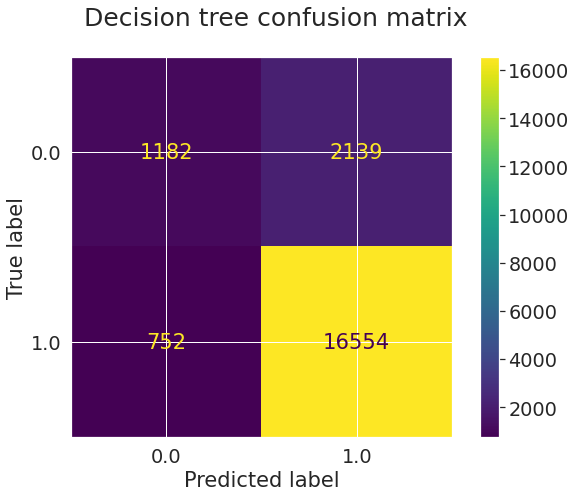

In [261]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale = 1.75)
y_test_pred = dt_clf_gridcv.best_estimator_.predict(x_test)
y_train_pred = dt_clf_gridcv.best_estimator_.predict(x_train)
cm = confusion_matrix(y_test, y_test_pred, labels = dt_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = dt_clf_gridcv.best_estimator_.classes_)
disp.plot(ax = ax)
fig.suptitle('Decision tree confusion matrix', fontsize = 25)
plt.show()

In [262]:
print('Actual train data')
print(y_train[:100])
print('Predicted train data')
print(y_train_pred[:100])

Actual train data
9585     1.0
82491    1.0
65188    1.0
48511    1.0
24333    0.0
        ... 
7076     0.0
57917    0.0
73942    1.0
74508    1.0
28730    1.0
Name: Score, Length: 100, dtype: float64
Predicted train data
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1.]


In [263]:
accuracy_training = accuracy_score(y_train,y_train_pred)
accuracy_test = accuracy_score(y_test,y_test_pred)
print(f'Decision tree model')
print(f'Accuracy Training Data: {accuracy_training}')
print(f'Accuracy Test Data: {accuracy_test}')

Decision tree model
Accuracy Training Data: 0.9143234595433171
Accuracy Test Data: 0.8598438939254376


In [264]:
print(f'Decision tree model')
print(classification_report(y_test, y_test_pred))

Decision tree model
              precision    recall  f1-score   support

         0.0       0.61      0.36      0.45      3321
         1.0       0.89      0.96      0.92     17306

    accuracy                           0.86     20627
   macro avg       0.75      0.66      0.68     20627
weighted avg       0.84      0.86      0.84     20627



# Random Forest Classifier

In [265]:
rf_clf = RandomForestClassifier(random_state=42)

In [268]:
%%time
parameters = {
    'n_estimators': (50,100,200,300),
    'max_depth':(50,100,200,300)
}
rf_clf_gridcv = GridSearchCV(rf_clf, parameters, cv=5, 
                                     scoring='accuracy',verbose=1)
rf_clf_gridcv.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 48min 11s, sys: 10.6 s, total: 48min 22s
Wall time: 48min 9s


In [269]:
cv_result = pd.DataFrame(rf_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
3,"{'max_depth': 50, 'n_estimators': 300}",0.922286,1
7,"{'max_depth': 100, 'n_estimators': 300}",0.922274,2
11,"{'max_depth': 200, 'n_estimators': 300}",0.922274,2
15,"{'max_depth': 300, 'n_estimators': 300}",0.922274,2
6,"{'max_depth': 100, 'n_estimators': 200}",0.922189,5
10,"{'max_depth': 200, 'n_estimators': 200}",0.922189,5
14,"{'max_depth': 300, 'n_estimators': 200}",0.922189,5
2,"{'max_depth': 50, 'n_estimators': 200}",0.922177,8
5,"{'max_depth': 100, 'n_estimators': 100}",0.922117,9
9,"{'max_depth': 200, 'n_estimators': 100}",0.922117,9


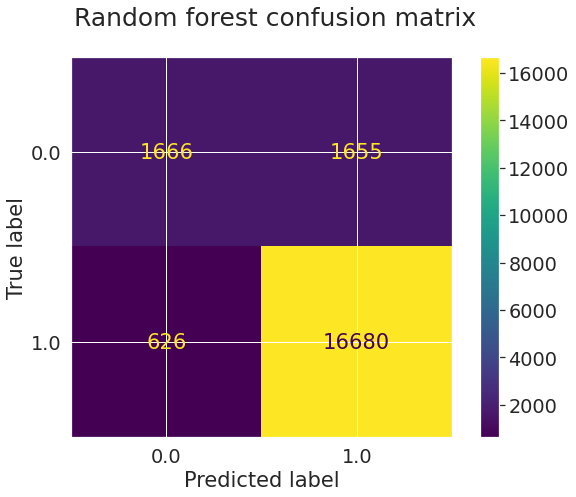

In [270]:
fig, ax = plt.subplots(figsize=(10,7))
y_test_pred = rf_clf_gridcv.best_estimator_.predict(x_test)
y_train_pred = rf_clf_gridcv.best_estimator_.predict(x_train)
cm = confusion_matrix(y_test, y_test_pred, labels = rf_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rf_clf_gridcv.best_estimator_.classes_)
disp.plot(ax = ax)
fig.suptitle('Random forest confusion matrix', fontsize = 25)
plt.show()

In [271]:
print(f'Random forest model')
print(f'Actual train data')
print(y_train[:100])
print(f'Predicted train data')
print(y_train_pred[:100])

Random forest model
Actual train data
9585     1.0
82491    1.0
65188    1.0
48511    1.0
24333    0.0
        ... 
7076     0.0
57917    0.0
73942    1.0
74508    1.0
28730    1.0
Name: Score, Length: 100, dtype: float64
Predicted train data
[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1.]


In [272]:
accuracy_training = accuracy_score(y_train,y_train_pred)
accuracy_test = accuracy_score(y_test,y_test_pred)
print(f'Random forest model')
print(f'Accuracy Training Data: {accuracy_training}')
print(f'Accuracy Test Data: {accuracy_test}')

Random forest model
Accuracy Training Data: 0.9999272797789305
Accuracy Test Data: 0.8894167838270228


In [273]:
print(f'Random Forest Model')
print(classification_report(y_test, y_test_pred))

Random Forest Model
              precision    recall  f1-score   support

         0.0       0.73      0.50      0.59      3321
         1.0       0.91      0.96      0.94     17306

    accuracy                           0.89     20627
   macro avg       0.82      0.73      0.76     20627
weighted avg       0.88      0.89      0.88     20627



# Gradient Boosting Classifier

In [275]:
gb_clf = GradientBoostingClassifier(random_state=42)

In [283]:
%%time
parameters = {
    'n_estimators': (100,200,300),
    'max_depth':(5,10,20)
}
gb_clf_gridcv = GridSearchCV(gb_clf, parameters, cv=3, 
                                     scoring='accuracy',verbose=2)
gb_clf_gridcv.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=  53.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=  51.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=  53.0s
[CV] END ......................max_depth=5, n_estimators=200; total time= 1.7min
[CV] END ......................max_depth=5, n_estimators=200; total time= 1.7min
[CV] END ......................max_depth=5, n_estimators=200; total time= 1.7min
[CV] END ......................max_depth=5, n_estimators=300; total time= 2.6min
[CV] END ......................max_depth=5, n_estimators=300; total time= 2.6min
[CV] END ......................max_depth=5, n_estimators=300; total time= 2.6min
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=10, n_est

In [284]:
cv_result = pd.DataFrame(gb_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
5,"{'max_depth': 10, 'n_estimators': 300}",0.920917,1
8,"{'max_depth': 20, 'n_estimators': 300}",0.920590,2
7,"{'max_depth': 20, 'n_estimators': 200}",0.920032,3
4,"{'max_depth': 10, 'n_estimators': 200}",0.919523,4
6,"{'max_depth': 20, 'n_estimators': 100}",0.917596,5
3,"{'max_depth': 10, 'n_estimators': 100}",0.916711,6
2,"{'max_depth': 5, 'n_estimators': 300}",0.909718,7
1,"{'max_depth': 5, 'n_estimators': 200}",0.908857,8
0,"{'max_depth': 5, 'n_estimators': 100}",0.907245,9


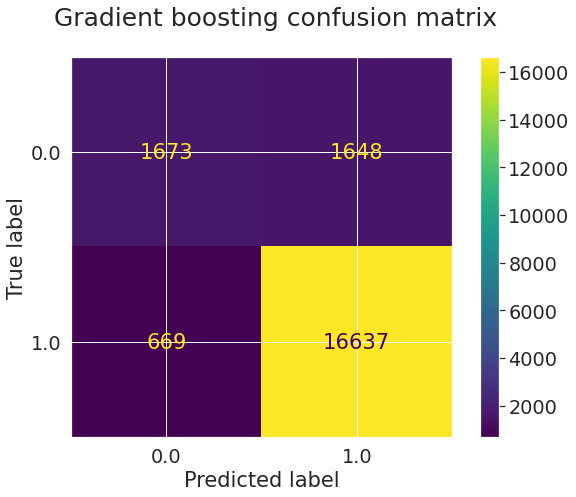

In [285]:
fig, ax = plt.subplots(figsize=(10,7))
y_test_pred = gb_clf_gridcv.best_estimator_.predict(x_test)
y_train_pred = gb_clf_gridcv.best_estimator_.predict(x_train)
cm = confusion_matrix(y_test, y_test_pred, labels = gb_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = gb_clf_gridcv.best_estimator_.classes_)
disp.plot(ax = ax)
fig.suptitle('Gradient boosting confusion matrix', fontsize = 25)
plt.show()

In [286]:
print(f'Gradient boosting model')
print(f'Actual train data')
print(y_train[:100])
print(f'Predicted train data')
print(y_train_pred[:100])

Gradient boosting model
Actual train data
9585     1.0
82491    1.0
65188    1.0
48511    1.0
24333    0.0
        ... 
7076     0.0
57917    0.0
73942    1.0
74508    1.0
28730    1.0
Name: Score, Length: 100, dtype: float64
Predicted train data
[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1.]


In [287]:
accuracy_training = accuracy_score(y_train,y_train_pred)
accuracy_test = accuracy_score(y_test,y_test_pred)
print(f'Gradient boosting model')
print(f'Accuracy Training Data: {accuracy_training}')
print(f'Accuracy Test Data: {accuracy_test}')

Gradient boosting model
Accuracy Training Data: 0.9966063896834246
Accuracy Test Data: 0.8876714985213555


In [288]:
print(f'Gradient boosting model')
print(classification_report(y_test, y_test_pred))

Gradient boosting model
              precision    recall  f1-score   support

         0.0       0.71      0.50      0.59      3321
         1.0       0.91      0.96      0.93     17306

    accuracy                           0.89     20627
   macro avg       0.81      0.73      0.76     20627
weighted avg       0.88      0.89      0.88     20627



In [302]:
b_clf = BaggingClassifier(random_state=42)


In [310]:
%%time

parameters = {
    'n_estimators': (300,400,500),
  }
  
b_clf_gridcv = GridSearchCV( b_clf,parameters,cv=3,
             scoring='accuracy',verbose=2)
b_clf_gridcv.fit(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...................................n_estimators=300; total time= 4.8min
[CV] END ...................................n_estimators=300; total time= 4.7min
[CV] END ...................................n_estimators=300; total time= 4.7min
[CV] END ...................................n_estimators=400; total time= 6.4min
[CV] END ...................................n_estimators=400; total time= 6.3min
[CV] END ...................................n_estimators=400; total time= 6.3min
[CV] END ...................................n_estimators=500; total time= 7.9min
[CV] END ...................................n_estimators=500; total time= 7.8min
[CV] END ...................................n_estimators=500; total time= 7.8min
CPU times: user 1h 8min 51s, sys: 15.4 s, total: 1h 9min 6s
Wall time: 1h 8min 54s


In [311]:
cv_result = pd.DataFrame(b_clf_gridcv.cv_results_)
retain_cols = ['params', 'mean_test_score', 'rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')



,params,mean_test_score,rank_test_score
2,{'n_estimators': 500},0.920250,1
1,{'n_estimators': 400},0.920226,2
0,{'n_estimators': 300},0.920105,3


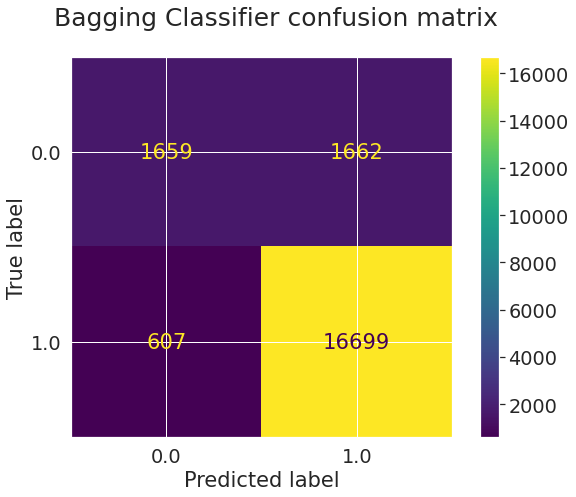

In [312]:
# bagging classifier confusion matrix

fig, ax = plt.subplots(figsize=(10, 7))
y_test_pred = b_clf_gridcv.best_estimator_.predict(x_test)
y_train_pred = b_clf_gridcv.best_estimator_.predict(x_train)
cm = confusion_matrix(y_test, y_test_pred, labels=b_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=b_clf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
fig.suptitle('Bagging Classifier confusion matrix', fontsize=25)
plt.show()

In [314]:
# accuracy calc
accuracy_training = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f'Bagging Classifier model')
print(f'Accuracy Training Data: {accuracy_training}')
print(f'Accuracy Test Data: {accuracy_test}')


Bagging Classifier model
Accuracy Training Data: 0.9999272797789305
Accuracy Test Data: 0.8899985455955786
